## Purpose
This notebook creates cleans up the datasets from the following resources and plots for exploratory data analysis
* Turnstile Data from url: http://web.mta.info/developers/turnstile.html
* MTA Subway stations with locations(lat-lon) url: http://web.mta.info/developers/data/nyct/subway/Stations.csv
* The public data from US government American Community Survey 2015 5-year estimate from url: https://www.kaggle.com/muonneutrino/new-york-city-census-data?select=census_block_loc.csv
* ACS data estimates for each census tract in New York city from url: https://www.kaggle.com/muonneutrino/new-york-city-census-data?select=nyc_census_tracts.csv

#### Steps for cleaning up:
1. Get the census tract number we want (from nyc_census_tracts dataset)
2. Find the blocks within the census tract (from census_block_loc dataset)
3. Find the station/stop name and line/daily route combinations within those blocks (from Stations dataset)
4. Find the matching combinations (from MTA dataset)

#### Loading Modules

In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gmaps
import gmaps.datasets
%matplotlib inline 
from datetime import datetime
from fuzzywuzzy import fuzz
import re

In [2]:
def get_data(week_nums):
    """
    Author: Richard Chiou
    Helper function to load data from MTA turnstile source
    """
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)

#### Loading Datasets
>* nyc_census_tracts: demographic data with census tract codes
>* census_block_loc: data with locations(lon-lat) of each census block(sub-level of census tract) codes
>* station_data: data with locations(lon-lat) of stations in NYC and info of the stations
>* df2019: MTA turnstile data from 07/06/2019 to 10/04/2019

In [3]:
nyc_census_tracts = pd.read_csv('data/nyc_census_tracts.csv') # Census tract code and Poverty proportion
census_block_loc = pd.read_csv('data/census_block_loc.csv') # Locations of census block(sub-level of tract)
census_block_loc['CensusTract'] = census_block_loc.BlockCode.map(lambda x: x // 10000)
station_data = pd.read_csv('data/stations_with_tract_id.csv') # Locations of stations

week_nums = [190713, 190720, 190727, 190803, 190810, 190817, 190824, 190831, 190907, 190914, 190921, 190928 ,191005]
df2019 = get_data(week_nums)

#### Adding new variable 'Total_Poverty' as the population under poverty level and retrieving census tract numbers in the top 4 total poverty census tracts

In [4]:
nyc_census_tracts['Total_Poverty'] = nyc_census_tracts['Poverty'].multiply(nyc_census_tracts['TotalPop']).multiply(1/100)
stations_with_census = pd.merge(station_data,
                                nyc_census_tracts[['CensusTract', 'Poverty', 'TotalPop', 'Total_Poverty']],
                                left_on='Census Tract', 
                                right_on='CensusTract')

# Get the tract numbers of top 4 Total_Poverty census tracts
tract_numbers = stations_with_census.sort_values('Total_Poverty', ascending=False).head(4)['Census Tract'].values
stations_with_census.sort_values('Total_Poverty', ascending=False).head(4)

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,Census Block,Census Tract,CensusTract,Poverty,TotalPop,Total_Poverty
269,234,234,F16,IND,6th Av - Culver,East Broadway,M,F,Subway,40.713715,-73.990173,Uptown & Queens,Brooklyn,360610006001001,36061000600,36061000600,44.7,12554,5611.638
192,156,156,A18,IND,8th Av - Fulton St,103 St,M,B C,Subway,40.796092,-73.961454,Uptown & The Bronx,Downtown & Brooklyn,360610189002000,36061018900,36061018900,36.0,12825,4617.000
166,135,135,L26,BMT,Canarsie,Livonia Av,Bk,L,Elevated,40.664038,-73.900571,Manhattan,Canarsie - Rockaway Parkway,360470910004004,36047091000,36047091000,67.3,6094,4101.262
167,349,349,254,IRT,Eastern Pky,Junius St,Bk,3,Elevated,40.663515,-73.902447,Manhattan,New Lots,360470910003000,36047091000,36047091000,67.3,6094,4101.262


#### Find the stations within the selected census tracts

In [5]:
stations = station_data[station_data['Census Tract'].map(lambda x: x in tract_numbers)]
stop_name_list = list(stations['Stop Name'].unique())# Create a list of stations within the selected census tracts
blocks = census_block_loc[census_block_loc.CensusTract.map(lambda x: x in tract_numbers)].sort_values('BlockCode')

station_list = df2019.STATION.unique() # Create a station list from MTA dataset

#### Strip puncutations and uppercase Stop Name's and STATION's and match them using fuzzywuzzy module

In [6]:
stripped_station = pd.Series(station_list).map(lambda x: ''.join(re.findall(r'[\w\.]', x)))
stripped_stop_name_list = [''.join(re.findall(r'[\w\.]', x)).upper() for x in stop_name_list]

# Match the Stop Name to STATION using fuzzywuzzy module
closest_index = []
for stop_name in stripped_stop_name_list:
    closest_index.append(stripped_station.map(lambda x: fuzz.ratio(x, stop_name)).idxmax())
    
# Find the stations from MTA dataset that match the stations' names in Stations.csv
top_stations = station_list[closest_index]
sorted(top_stations)

['103 ST', 'EAST BROADWAY', 'JUNIUS ST', 'LIVONIA AV']

#### Find a list of STATION and LINENAME's from MTA datset that matches the selected stations only.<br>
There can be more than 1 lines in the selected stations.

In [7]:
mta = df2019[df2019.STATION.map(lambda x: x in top_stations)]
sorted(mta.set_index(['STATION','LINENAME']).index.unique())

[('103 ST', '1'),
 ('103 ST', '6'),
 ('103 ST', 'BC'),
 ('EAST BROADWAY', 'F'),
 ('JUNIUS ST', '3'),
 ('LIVONIA AV', 'L')]

#### Reformat values of 'Daytime Routes' and 'Stop Name' into 'LINENAME' and 'STATION' in MTA dataset for matching

In [8]:
pd.options.mode.chained_assignment = None  # default='warn'

stations['Daytime Routes'] = stations['Daytime Routes'].apply(lambda x: x.replace(" ",""))

for index in range(len(stop_name_list)):
    stations.loc[stations['Stop Name'] == stop_name_list[index], 'Stop Name'] = top_stations[index]
stations[['Stop Name', 'Daytime Routes']].sort_values(['Stop Name', 'Daytime Routes'])

,Stop Name,Daytime Routes
155,103 ST,BC
234,EAST BROADWAY,F
349,JUNIUS ST,3
134,LIVONIA AV,L


#### Find which lines belong to the station and store it in a separate dictionary called 'statline'.

In [9]:
from collections import defaultdict
statlines = defaultdict(list)
for station_name in top_stations:
    stations_set = set(stations.loc[stations['Stop Name'] == station_name, 'Daytime Routes'])
    mta_set = set(mta.loc[mta.STATION == station_name, 'LINENAME'])
    for daytime_route in stations_set:
        mask = [set(daytime_route).issubset(set(item)) for item in mta_set]
        statlines[station_name] += [target for boolean, target in zip(mask, mta_set) if boolean]
# sorted(statlines.items())

#### Finally, create 'final_df' and store the targeted Station and Line combinations from MTA dataset.

In [10]:
final_df = pd.DataFrame()
for station_name, line_list in statlines.items():
    for line in line_list:
        final_df = final_df.append(mta[(mta.LINENAME == line) & (mta.STATION == station_name)])
final_df = final_df.rename(columns = {final_df.columns[-1] : final_df.columns[-1].strip()})# Strip whitespace from 'EXITS' column

## Traffic

#### Create necessary/supplementary columns to compute traffic per day and time<br>
* Necessary columns for the main presentation
> * STATLINE: Station and Linename in a tuple
> * DATETIME: Date and Time combined
> * DIFF_ENTRIES: The number of entries at a turnstile at each datetime which is the difference in cumulative entries between the adjacent values of ENTRIES field
> * DIFF_EXITS: The number of exits at a turnstile at each datetime
> * DAY: Day at the recording in datetime.dt.dayofweek format (0 = Monday, ..., 6 = Sunday)
> * RIDERSHIP: The number of people(a.k.a traffic) at the recording as the sum of DIFF_ENTRIES and DIFF_EXITS
<br><br>
* Supplementary columns for the appendix to the presentation
> * TIME_TIME: TIME in datetime.dt.time format
> * TIME_INT: TIME in integer
> * DIFF_HRS: The length of time window between the previous and the current recording
> * DIFF_HRS_ROUND: Rounded DIFF_HRS to the nearest hour
> * TIME_ROUND: Rounded TIME to the nearest hour
> * DIFF_ENTRIES_PER_HR: Entries per (rounded) hour = DIFF_ENTRIES / DIFF_HRS_ROUND
> * DIFF_EXITS_PER_HR: Exits per (rounded) hour = DIFF_EXITS / DIFF_HRS_ROUND

In [11]:
final_df = final_df.reset_index()
final_df['STATION_LINENAME'] = list(zip(final_df.STATION, final_df.LINENAME))
final_df['DATETIME'] = pd.to_datetime(final_df[['DATE', 'TIME']].apply(lambda x: ' '.join(x), axis = 1))
final_df['DIFF_ENTRIES'] = final_df.sort_values(['C/A','UNIT','SCP','STATION','DATETIME']).groupby(['C/A','UNIT','SCP','STATION'])['ENTRIES'].transform(pd.Series.diff)
final_df['DIFF_EXITS'] = final_df.sort_values(['C/A','UNIT','SCP','STATION','DATETIME']).groupby(['C/A','UNIT','SCP','STATION'])['EXITS'].transform(pd.Series.diff)
final_df['DAY'] = final_df['DATETIME'].dt.dayofweek # 0 = Monday

# Replace negative DIFF_ENTRIES and DIFF_EXITS with ENTRIES and EXITS (turnstiles have been reset)
final_df.loc[final_df.DIFF_ENTRIES < 0, 'DIFF_ENTRIES'] = final_df.loc[final_df.DIFF_ENTRIES < 0, 'ENTRIES'] 
final_df.loc[final_df.DIFF_EXITS < 0, 'DIFF_EXITS'] = final_df.loc[final_df.DIFF_EXITS < 0, 'EXITS']
final_df['RIDERSHIP'] = final_df['DIFF_ENTRIES'] + final_df['DIFF_EXITS']

final_df['TIME_TIME'] = pd.to_datetime(final_df['TIME']).dt.time # Convert TIME to timestamp time
final_df['TIME_INT'] = final_df['TIME'].map(lambda x: int(x[:2])) # Convert TIME to int hour
final_df['DIFF_HRS'] = final_df.sort_values(['C/A','UNIT','SCP','STATION','DATETIME']).groupby(['C/A','UNIT','SCP','STATION'])['DATETIME'].transform(pd.Series.diff)
final_df['DIFF_HRS_ROUND'] = final_df.loc[:,'DIFF_HRS'].dt.round('H').map(lambda x: np.timedelta64(x, 'h').astype(int) if pd.notnull(x) else x)
final_df['TIME_ROUND'] = pd.to_datetime(final_df['TIME']).dt.round('H').dt.time
mask = final_df.DIFF_HRS_ROUND.map(lambda x: pd.notnull(x))
final_df.loc[mask,'DIFF_ENTRIES_PER_HR'] = final_df.loc[mask, 'DIFF_ENTRIES'] / final_df.loc[mask, 'DIFF_HRS_ROUND']
final_df.loc[mask,'DIFF_EXITS_PER_HR'] = final_df.loc[mask, 'DIFF_EXITS'] / final_df.loc[mask, 'DIFF_HRS_ROUND']

print("NUMBER OF NEGATIVE DIFF_ENTRIES: ",final_df.loc[final_df.DIFF_ENTRIES < 0, 'DIFF_ENTRIES'].count())
print("NUMBER OF NEGATIVE DIFF_EXITS: ",final_df.loc[final_df.DIFF_EXITS < 0, 'DIFF_EXITS'].count())
print(sum(final_df.TIME.map(lambda x: str(x)[-5:] != '00:00')), 'rows have TIME that has minutes or seconds.')
print(len(final_df.DIFF_HRS[final_df.DIFF_HRS != '04:00:00']), 'rows have a time window other than 4 hours.')
print('final_df has',len(final_df),'rows')

NUMBER OF NEGATIVE DIFF_ENTRIES:  0
NUMBER OF NEGATIVE DIFF_EXITS:  0
134 rows have TIME that has minutes or seconds.
239 rows have a time window other than 4 hours.
final_df has 12639 rows


#### Store the final_df in another variable and remove the recordings with irregular time window

In [12]:
w_non4time_final_df = final_df
final_df = final_df.loc[final_df.DIFF_HRS == '04:00:00',:]

In [13]:
print(f"There are {len(final_df.groupby(['C/A', 'UNIT', 'SCP', 'STATION']).count())} turnstiles in the targeted area.") # 23 turnstiles in top 1 tract
print(f"{len(df2019.groupby(['C/A', 'UNIT', 'SCP', 'STATION']).count())} turnstiles in total from 7/6/2019 to 10/4/2019.") # 4955 turnstiles in total
print(f"{round((23/4955)*100,1)}% of the total turnstiles are targeted.")

There are 23 turnstiles in the targeted area.
4955 turnstiles in total from 7/6/2019 to 10/4/2019.
0.5% of the total turnstiles are targeted.


#### The distribution of traffic for 4 hours

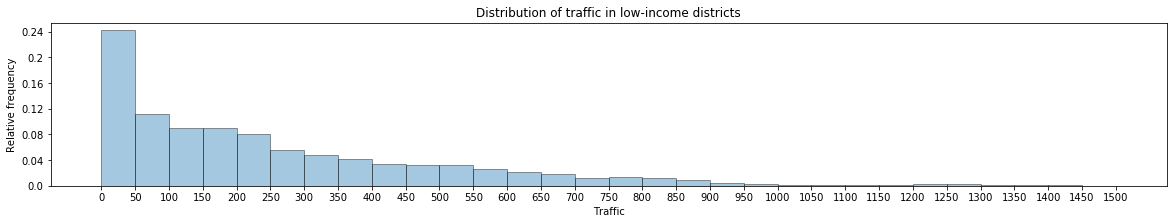

In [14]:
plt.figure(figsize=(20,3)); xmax = int(final_df.RIDERSHIP.max())
g = sns.distplot(final_df.RIDERSHIP, bins = np.linspace(0, 1500, 31),kde = False, hist_kws=dict(edgecolor="k"));
g.set_xticks(range(0,xmax + 50,50))
g.set_xticklabels(list(range(0,xmax + 50,50)))
g.set_yticks(range(0, 3500, 500))
g.set_yticklabels([round(x/final_df.RIDERSHIP.count(),2) for x in list(range(0, 3500, 500))])
g.set_title('Distribution of traffic in low-income districts')
g.set_xlabel('Traffic'); g.set_ylabel('Relative frequency');

The traffic is heavily right-skewed upto 1450 people during 4 hours.

#### Plots:
* Proportion of Traffic for each Station and Line combination
* Proportion of Traffic for each Station, Line, and Time combination

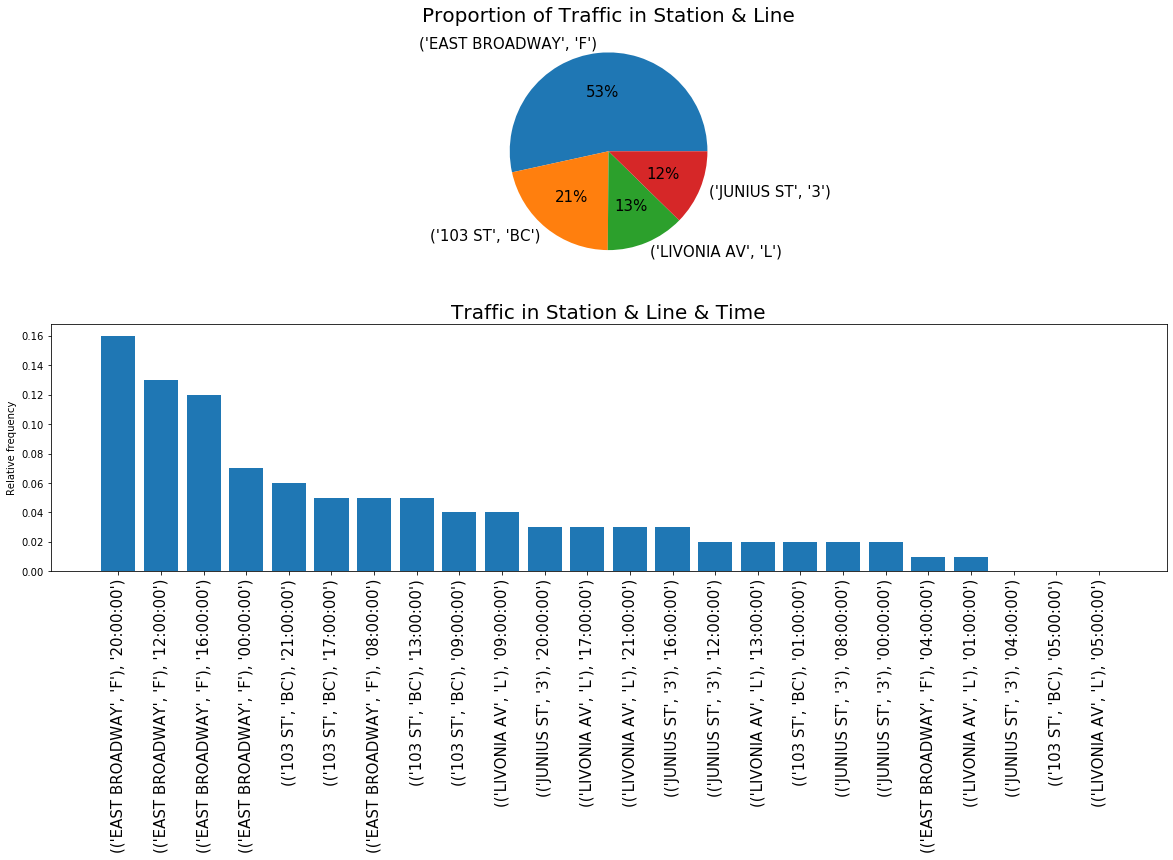

In [15]:
statline_names = [('103 ST', 'BC'), ('EAST BROADWAY', 'F'), ('JUNIUS ST', '3'), ('LIVONIA AV', 'L')]
diff_statline_time = \
final_df.groupby(['STATION_LINENAME', 'TIME']).sum()['RIDERSHIP'].sort_values(ascending = False) # Traffic per statline & time in descending order
labels = diff_statline_time.index.map(lambda x: str(x))

diff_statline = \
final_df.groupby(['STATION_LINENAME']).sum()['RIDERSHIP'].sort_values(ascending = False) # Traffic per statline in descending order

fig, ax = plt.subplots(2, 1, figsize = (20, 5))
fig.set_figwidth(20)
fig.set_figheight(10)

ax[0].pie(diff_statline, labels = diff_statline.index, 
          autopct='%1.0f%%', textprops = {'fontsize': 15});
ax[0].set_title('Proportion of Traffic in Station & Line', fontsize = 20)
ax[1].bar(labels, round(diff_statline_time/sum(diff_statline_time),2))
ax[1].tick_params(labelrotation=90, labelsize=15, axis='x')
ax[1].set_ylabel('Relative frequency')
ax[1].set_title('Traffic in Station & Line & Time', fontsize = 20);

#### Comparison of median traffic across days at each station

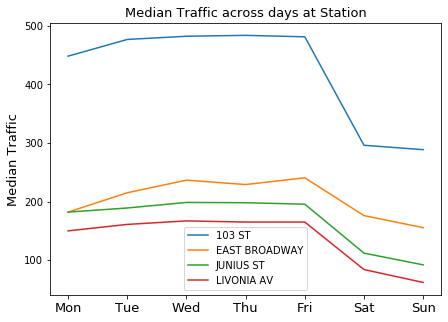

In [16]:
plt.figure(figsize=(7,5))
for statline_name in statline_names:
    plt.plot(final_df.loc[final_df.STATION_LINENAME == statline_name].groupby(['DAY']).median().RIDERSHIP, label = statline_name[0])
plt.legend(loc=0)
plt.xticks(list(range(7)),['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],fontsize=13)
plt.ylabel('Median Traffic',fontsize=13)
plt.title('Median Traffic across days at Station',fontsize=13);

### Appendix
Regarding using median as the summary statistic and irregular window outliers

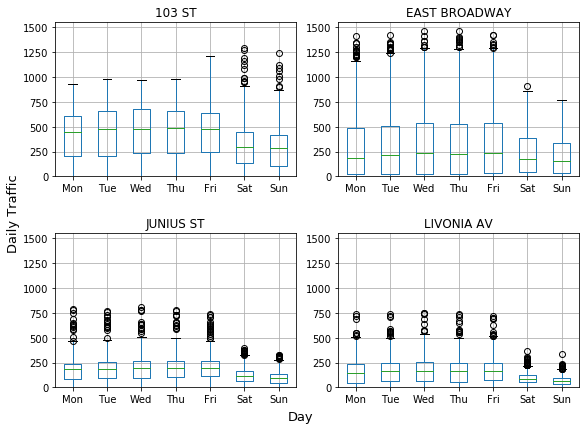

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(8,6))
for i, statline_name in enumerate(statline_names):
    final_df.loc[(final_df.STATION_LINENAME == statline_name), ['DAY','RIDERSHIP']].\
    boxplot(by = ['DAY'],figsize=(10,3), ax=ax.flatten()[i])
plt.suptitle('',y=1.02)
plt.tight_layout(pad = 1.0) 
k = 0
for i in range(2):
    for j in range(2):
        ax[i, j].set_title(statline_names[k][0])
        ax[i, j].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontdict=None, minor=False);
        ax[i, j].set_xlabel(''); ax[i, j].set_ylabel(''); ax[i, j].set_ylim(0, 1550)
        k += 1
fig.text(0.5, 0.02, 'Day', ha='center', fontsize=13)
fig.text(-0.01, 0.5, 'Daily Traffic', va='center', rotation='vertical', fontsize=13);

Can see how all these stations have right-skewed ridership across days. Medians are the representative summary statistic of daily ridership in this case.

#### Wrangling TIME variable to adjust to the regular time windows. 
e.g) If The station has (01:00, 05:00, 09:00, 13:00, 17:00, 21:00) sequence, irregular TIME value would be 08:00 and 
    this would be adjusted to 9:00 because it falls into the window of 05:00 to 09:00

In [18]:
# Temporary variable to adjust unusual time windows
tmp = w_non4time_final_df
tmp.TIME_ROUND = tmp.TIME_ROUND.map(lambda x: x.strftime('%H'))

# Add the irregular time to the corresponding window
tmp.loc[(tmp.STATION_LINENAME == statline_names[0]) & (tmp.TIME_ROUND == '08'), 'TIME_ROUND'] = '09'
tmp.loc[(tmp.STATION_LINENAME == statline_names[0]) & (tmp.TIME_ROUND == '14'), 'TIME_ROUND'] = '17'

tmp.loc[(tmp.STATION_LINENAME == statline_names[1]) & (tmp.TIME_ROUND == '07'), 'TIME_ROUND'] = '08'
tmp.loc[(tmp.STATION_LINENAME == statline_names[1]) & (tmp.TIME_ROUND.map(lambda x: x in ['09','10'])), 'TIME_ROUND'] = '12'

tmp.loc[(tmp.STATION_LINENAME == statline_names[2]) & (tmp.TIME_ROUND.map(lambda x: x in ['09','10', '11'])), 'TIME_ROUND'] = '12'
tmp.loc[(tmp.STATION_LINENAME == statline_names[2]) & (tmp.TIME_ROUND == '13'), 'TIME_ROUND'] = '16'

tmp.loc[(tmp.STATION_LINENAME == statline_names[3]) & (tmp.TIME_ROUND == '10'), 'TIME_ROUND'] = '13'

#### Comparison between two data with and without outliers with respect to median traffic and time windows

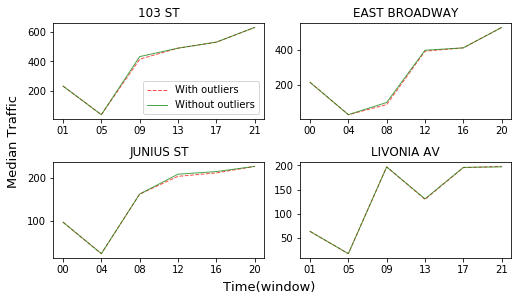

In [19]:
fig, ax = plt.subplots(2, 2, figsize = (7,4))
k = 0
for i in range(2):
    for j in range(2):
        ridership = tmp.loc[tmp.STATION_LINENAME == statline_names[k]].groupby('TIME_ROUND').median().RIDERSHIP
        ax[i,j].plot(ridership, label = 'With outliers', linewidth=1, alpha = .7, color='r', linestyle='dashed')

        ridership = final_df.loc[final_df.STATION_LINENAME == statline_names[k]].groupby('TIME_TIME').median().RIDERSHIP
        ax[i,j].plot(ridership.index.map(lambda x: x.strftime("%H")), ridership, label = 'Without outliers',linewidth=1, alpha = .7, color='g');
        ax[i,j].set_title(statline_names[k][0])
        k += 1
ax[0,0].legend(loc=0)
plt.tight_layout(pad = 1.0)
fig.text(0.5, -0.02, 'Time(window)', ha='center', fontsize=13)
fig.text(-0.02, 0.5, 'Median Traffic', va='center', rotation='vertical', fontsize=13);

The outliers with unusual time windows are adjusted towards the 4-hour window time frame. In this case, these outlier turnstile records do not change our inferences about the ridership at certain times at each station.

#### Comparison between two data with and without outliers with respect to median traffic and days

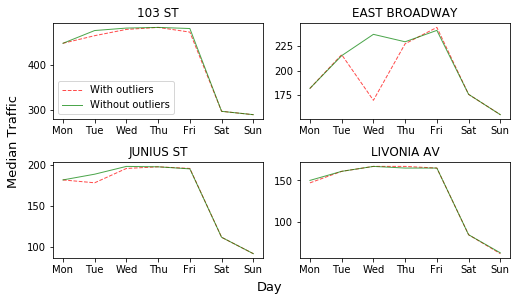

In [20]:
fig, ax = plt.subplots(2, 2, figsize = (7,4))
k = 0
for i in range(2):
    for j in range(2):
        ridership = tmp.loc[tmp.STATION_LINENAME == statline_names[k]].groupby('DAY').median().RIDERSHIP
        ax[i,j].plot(ridership, label = 'With outliers', linewidth=1, alpha = .7, color='r', linestyle='dashed')

        ridership = final_df.loc[final_df.STATION_LINENAME == statline_names[k]].groupby('DAY').median().RIDERSHIP
        ax[i,j].plot(ridership, label = 'Without outliers',linewidth=1, alpha = .7, color='g');
        ax[i,j].set_title(statline_names[k][0])
        ax[i, j].set_xticks(range(7))
        ax[i, j].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
        k += 1
ax[0,0].legend(loc=0)
plt.tight_layout(pad = 1.0)
fig.text(0.5, -0.02, 'Day', ha='center', fontsize=13)
fig.text(-0.02, 0.5, 'Median Traffic', va='center', rotation='vertical', fontsize=13);

Except that there is a chance that the ridership on Wednesday in East Broadway station may have been a bit overestimated in our analysis, our conclusions on the choice of station, day, and time are less likely to be changed. Also, the overestimation of median is less than 20 people which could be considered as negligible considering that most riderships are well over 150 people.